### Creates Datasets

<pre>
baseline_results.json
alpha_results.json
D_results.json
</pre>

### Plots and Tables created in this Notebook:

- Figure 9:  Relationship between training and testing accuracies for Task1 and Task2 models

- Table 6

#### Drilldowns  for each model (not included in paper, perhaps in appendix)

- Figures 18 and 19 (in appendix, not output here)
- Alphas vs Test Accuracies
- D vs Test Accuracioes



### The  Data

The Predicting Generalization Contest provides 2 public data sets, consisting of about 150 pretrained DNNs, of various depths and accuracies, with different hyperparameter settings.  These are

- **task2_v1**:  54 models trained on SVHN: *stacked Dense layers*
- **task1_v4**:  96 models trained on CIFAR10:  *like VGG models*
 
These are described in Figure 1 of the [contest description supplement](https://drive.google.com/file/d/1maCI6XNxlAGjtqgzo7WKlOdI4_WBmX1P/view)


![VGG-like models](img/models.png)



Note:  in  
 - the Dense layers are actually Conv2D(1,1,N,M) layers
 - there is a large flattening layer which does not  appear actual VGG models

We further break the tasks into models specific depths by their model number and the number of layers $L$:

**task1_v4** :  4 different depths $L$ , 24 models each  **CHECK THIS**
  - $L=2$: dw_128_conv_1_dense_1    0xx
  - $L=3$: dw_128_conv_1_dense_2    1xx, 2xx
  - $L=4$: dw_128_conv_3_dense_1    5xx, 6xx
  - $L=5$: dw_128_conv_3_dense_2    7xx


**task2_v12**:  3 different depths $L$, 18 models each
  - $L=12$: nin_depth_12_conv_512    2xx
  - $L=6$:  nin_depth_6_conv_512     6xx  
  - $L=9$:  nin_depth_9_conv_512     9xx, 10xx
  
We also distinguish between *solver hyperparameters*: 

- Batch size: {8, 32, 512}  
- Dropout rate: {0.0, 0.5}
- Weight decay: {0.0, 0.001}

and architecture variations, such as depth, and/or the Convolution width: 256 or  512.




In [1]:
!pip install tabulate

In [2]:
import numpy as np
import pandas as pd
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import scipy.stats as stats
from scipy.stats import kendalltau, spearmanr
import json, glob

import import_ipynb
import Utils as U

from tabulate import tabulate
from contextlib import redirect_stdout

import matplotlib
import matplotlib.pyplot as plt
from pylab import rcParams
from matplotlib.ticker import StrMethodFormatter
%matplotlib inline

%load_ext watermark
%watermark

importing Jupyter notebook from Utils.ipynb
2021-05-25T22:30:44-07:00

CPython 3.8.5
IPython 7.18.1

compiler   : Clang 10.0.0 
system     : Darwin
release    : 17.7.0
machine    : x86_64
processor  : i386
CPU cores  : 12
interpreter: 64bit


### Baseline Training vs Test Accuracy

FIGURE 9

In [3]:
IMG_DIR = "./img"
PAPER_DIR = "../paper"

baseline_results = {}
alpha_results = {}
ahat_results = {}
D_results = {}

for task in ["task1_v4", "task2_v1"]:
    baseline_results[task] = {}
    alpha_results[task] = {}
    D_results[task] = {}
    ahat_results[task] = {}

### NOTE:  this computes the negative (-)Ktau 

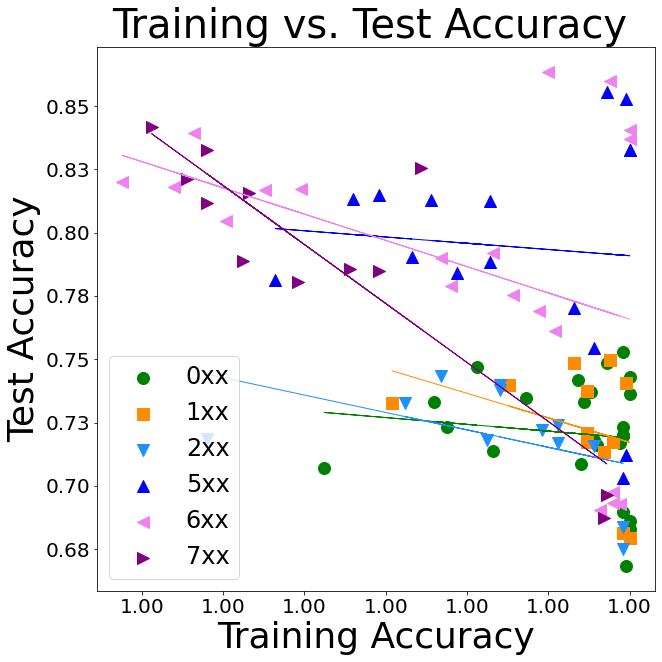

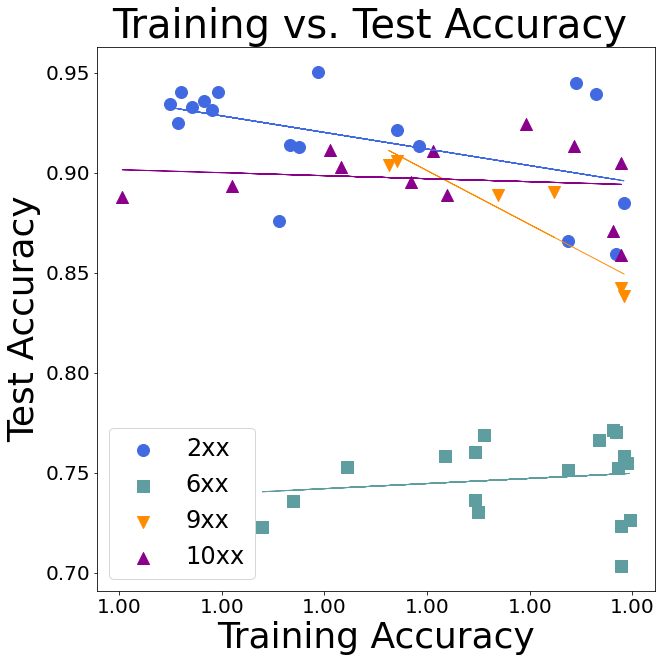

In [4]:
rcParams['figure.figsize'] = 10,10
rcParams['lines.markersize'] = U.MARKER_SIZE


results = {}

test_accuracies, training_accuracies = U.read_accuracies()

for task in ["task1_v4", "task2_v1"]:
             
    results[task]={}
    last_model_num = None
    xs, ys = {}, {}
    for mid, train_acc in training_accuracies[task].items():
        test_acc = test_accuracies[task][mid]
        color = U.mid_color(task,mid)
        marker = U.mid_shape(task,mid)
        model_num = U.model_num(mid)
        if last_model_num != model_num:
            plt.scatter(train_acc, test_acc, color=color, marker=marker, label="{}xx".format(model_num))
            last_model_num = model_num   
        else:
            plt.scatter(train_acc, test_acc, color=color, marker=marker)
          
        # add individal regression lines
        if model_num not in xs:
            xs[model_num], ys[model_num] = [], []
        xs[model_num].append(train_acc)
        ys[model_num].append(test_acc)
        
    for model_num in xs.keys():
        x = np.array(xs[model_num]).reshape(-1,1)
        y = np.array(ys[model_num]).reshape(-1,1)
        regr = linear_model.LinearRegression()
        regr.fit(x, y)
        y_pred = regr.predict(x)
        color = U.mid_color(task,model_num*100)

        plt.plot(x, y_pred, color=color, linewidth=1)

        R2 = r2_score(y, y_pred)
        RMSE = np.sqrt(mean_squared_error(y, y_pred))
        Ktau, p_value = stats.kendalltau(x, -y) 
        

        results[task]["{}xx".format(model_num)]={"R2":R2, "RMSE":RMSE,"Ktau":Ktau }
            
    taskname = U.taskname(task)
    #plt.title("{}: Training vs Test Accuracy ".format(taskname))
    plt.title("Training vs. Test Accuracy ".format(taskname), fontsize=U.TITLE_SIZE)
    plt.xlabel('Training Accuracy', fontsize=U.AXIS_SIZE)
    plt.ylabel('Test Accuracy', fontsize=U.AXIS_SIZE)
    plt.legend(prop={'size': U.LEGEND_SIZE})
    plt.tick_params(axis='both', which='major', labelsize=U.TICK_SIZE)
    plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.2f}')) # 2 decimal places
    plt.gca().xaxis.set_major_formatter(StrMethodFormatter('{x:,.2f}')) # 2 decimal places

    plt.savefig("{}/train_vs_test_{}.png".format(IMG_DIR,taskname))
    plt.show()
    
    

## Table 6


In [5]:
def get_df(reaults, task):
    df = pd.DataFrame.from_dict(results[task])
    df['all'] = df[df.columns].apply(np.average, axis=1)
    return df.transpose()

df1 = get_df(results, "task1_v4")
df2 = get_df(results, "task2_v1")
df = pd.concat([df1, df2])

filename = "{}/table_6.tex".format(PAPER_DIR)
   
with open(filename, 'w') as f:
    with redirect_stdout(f):
        print(tabulate(df, headers='keys', tablefmt='latex'))

# Training Accuracy Baselines

#### Baseline  Correlation Metrics

- R-Squared (linear) : $R^2$ 
- Kendal tau (rank) : $\tau$

These plots don't appear

Currently Figures 18 and 19 in the Appendix

<ipython-input-6-4ef56620b48f>:54: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
<ipython-input-6-4ef56620b48f>:54: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


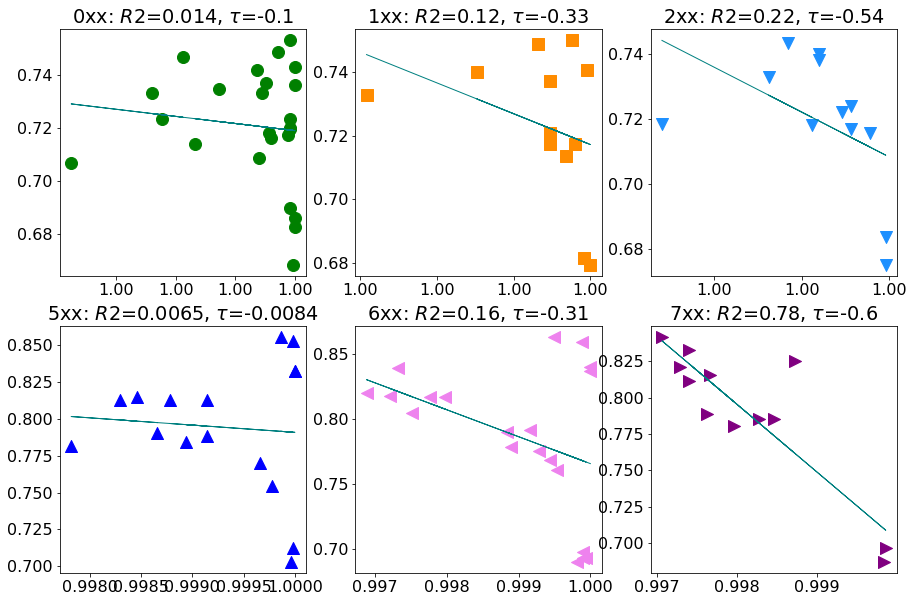

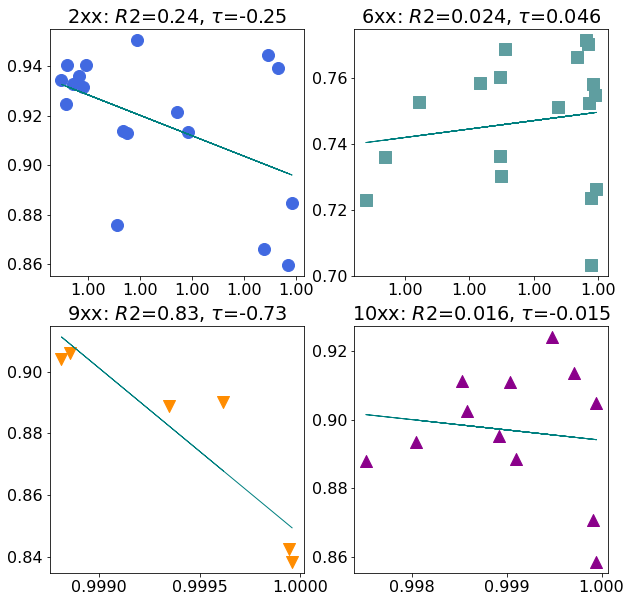

In [6]:
rcParams['figure.figsize'] = 5,5
rcParams.update({'font.size': 16})

test_group_accuracies, train_group_accuracies = U.read_modelgroup_accuracies()



for task, shape in zip(["task1_v4", "task2_v1"], [(2,3), (2,2)]):

    rcParams['figure.figsize'] = 5*shape[1],5*shape[0]
    fig, axes = plt.subplots(shape[0], shape[1])
    subplts = axes.flatten()[::-1].tolist()

    for ax in axes[0]:
        ax.minorticks_off()
        ax.yaxis.set_major_formatter(StrMethodFormatter('{x:,.2f}')) 
        ax.xaxis.set_major_formatter(StrMethodFormatter('{x:,.2f}')) 

    baseline_results[task]={}
    
    # TODO: get modelgroup accuracies ... not inidudual   
    for mid in train_group_accuracies[task].keys():
              
        train_accs = train_group_accuracies[task][mid]
        test_accs = test_group_accuracies[task][mid]
        
        x = [x[1] for x in train_accs]
        y = [y[1] for y in test_accs]
        
        color =  U.mid_color(task, mid*100)
        marker = U.mid_shape(task, mid*100)
    
        if len(x)> 0:
            subplt = subplts.pop()
            subplt.scatter(x, y, color=color, marker=marker)
            
            x = np.array(x).reshape(-1,1)
            y = np.array(y).reshape(-1,1)
            regr = linear_model.LinearRegression()
            regr.fit(x, y)
            y_pred = regr.predict(x)
            subplt.plot(x, y_pred, color='teal', linewidth=1)

            R2 = r2_score(y, y_pred)
            RMSE = np.sqrt(mean_squared_error(y, y_pred))
            MAE = mean_absolute_error(y, y_pred)

            tau, p_value = stats.kendalltau(x, y)   
            mgrp = "{}xx: ".format(mid)
            title = mgrp+r"$R2$={:0.2}, $\tau$={:0.2}".format(R2, tau)
            subplt.set_title(title) 
            
            baseline_results[task][mgrp]= {'R2':R2, "Ktau":tau, 'RMSE':RMSE}
    fig.show()


## WeightWatcher Generalization Metrics

We have run weightwacther for every model and saved the details dataframes.

WeightWatcher details dataframs should be in ../results

In [7]:
# fix keys for this notebook
this_task = "task1_v4"
all_details = U.read_details("task1_v4")


Read 96 details dataframes for task1_v4


In [8]:
#for metric in ['lognorm', 'alpha', 'alpha_weighted', 'logspectralnorm', 'logpnorm', 'D']:#'softrank', 'D']:

    
def plot_metric(metric, all_details, this_task, y_limit=109, subplt=None):
    
    results = {}
    
    if not subplt:
        fig, subplt = plt.subplots(1,1)
        
    x, y = [], []
    for mid, details in all_details.items():
        yval = details[metric].dropna().mean()

        if yval <= y_limit:
            #mid = model.replace("model_", '')
            test_accuracy = test_accuracies[this_task][int(mid)]

            x.append(test_accuracy)
            y.append(yval)
            subplt.annotate("{}".format(mid), (test_accuracy,yval))
            subplt.scatter(test_accuracy, yval)


    x = np.array(x).reshape(-1,1)
    y = np.array(y).reshape(-1,1)
    regr = linear_model.LinearRegression()
    regr.fit(x, y)
    y_pred = regr.predict(x)
    subplt.plot(x, y_pred, color='teal', linewidth=1)

    
    RMSE = np.sqrt(mean_squared_error(y, y_pred))
    MAE = mean_absolute_error(y, y_pred)
    R2 = r2_score(y, y_pred)
    Ktau, p_value = stats.kendalltau(x, y)
    spman, p_value = spearmanr(x, y)
    
    results['RMSE']=RMSE
    results['MAE']=MAE
    results['R2']=R2
    results['Ktau']=Ktau
    results['spman']=spman


    title = r"{} {}: $R^2=${:0.2} $\tau=${:0.2} sp={:0.2}".format(this_task, metric, R2, Ktau, spman)
    subplt.set_title(title)

    subplt.set_xlabel('test accuracy')
    subplt.set_ylabel(metric)
    
    return results

#### Task 1 Models 

**First, lets look at the weightwatcher tail exponent $\alpha$**

{'RMSE': 1.767171871433903,
 'MAE': 1.3078934866957963,
 'R2': 0.15232910152669543,
 'Ktau': -0.30953166093887224,
 'spman': -0.44913641961514156}

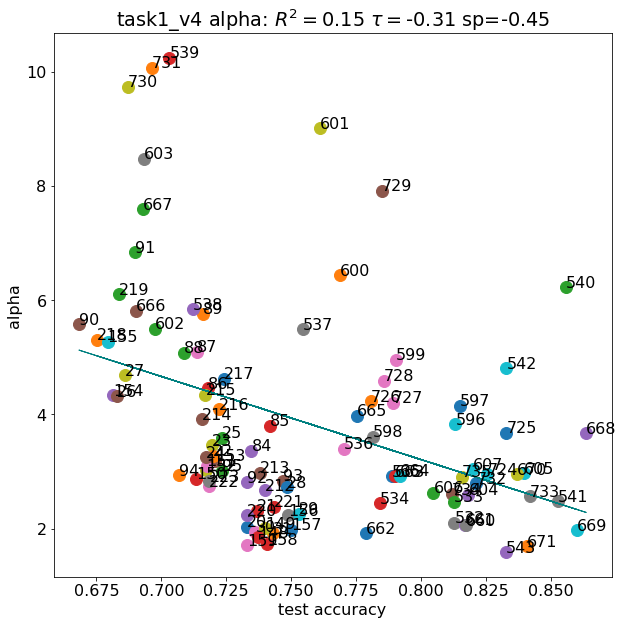

In [9]:
rcParams['figure.figsize'] = 10,10
rcParams.update({'font.size': 16})

plot_metric('alpha', all_details, this_task)

### Drill down and look at each model number xx, and compare to the baselines**

Comparing the $R^{2}$ regression correlation metric:



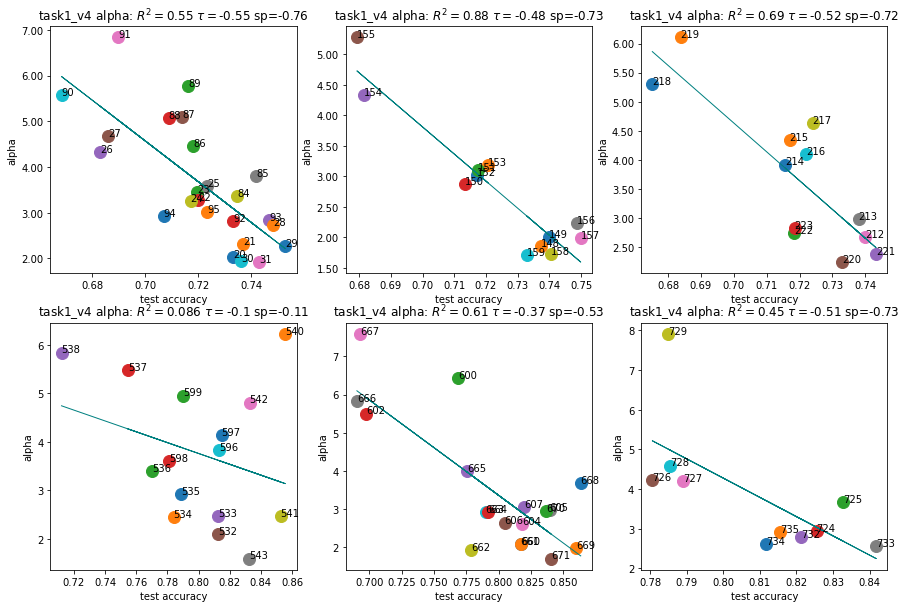

In [10]:
rcParams['figure.figsize'] = 15, 10
rcParams.update({'font.size': 10})

fig, axes = plt.subplots(2,3)
subplts = axes.flatten()[::-1].tolist()

for ax in axes[0]:
    ax.minorticks_off()
    ax.yaxis.set_major_formatter(StrMethodFormatter('{x:,.2f}')) 
    ax.xaxis.set_major_formatter(StrMethodFormatter('{x:,.2f}')) 
    
for mid in [0, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]:
    these_details = {}
    for model, df in all_details.items():
        this_mid = int(model)#model.replace("model_", ''))
                       
        if this_mid >= mid and this_mid < mid+100 :
            these_details[model]=df
        
    if len(these_details) > 0:
        subplt = subplts.pop()
        mgrp = U.model_group(mid)
        alpha_results[this_task][mgrp] = plot_metric('alpha', these_details, this_task, y_limit=8, subplt=subplt)


#### Better alpha $\alpha$,  better correlation ?



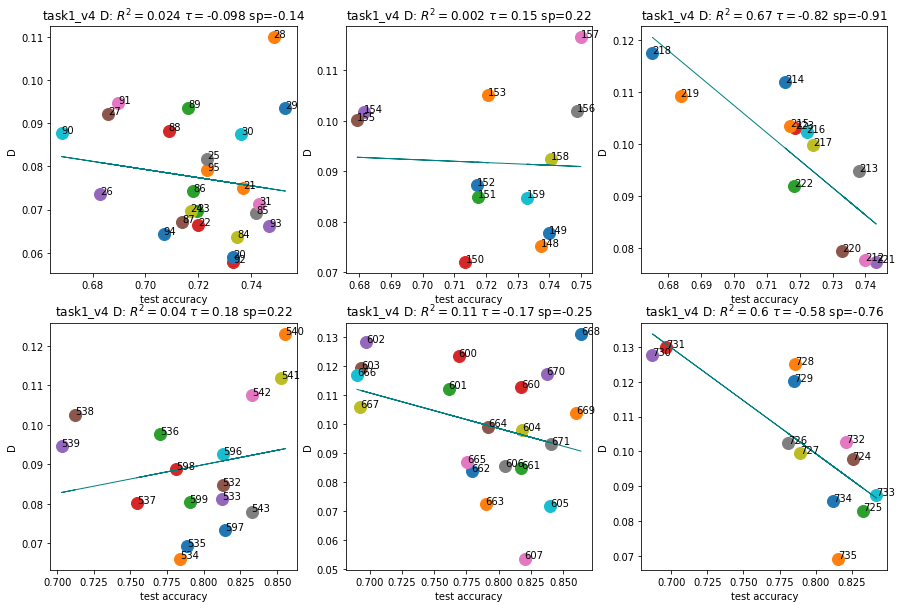

In [11]:
rcParams['figure.figsize'] = 15, 10
rcParams.update({'font.size': 10})

fig, axes = plt.subplots(2,3)
subplts = axes.flatten()[::-1].tolist()
    
for mid in [0, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]:
    these_details = {}
    for model, df in all_details.items():
        this_mid = int(model)#.replace("model_", ''))
                       
        if this_mid >= mid and this_mid < mid+100 :
            these_details[model]=df
        
    if len(these_details) > 0:
        subplt = subplts.pop()
        mgrp = U.model_group(mid)
        D_results[this_task][mgrp] = plot_metric('D', these_details, this_task, y_limit=8, subplt=subplt)

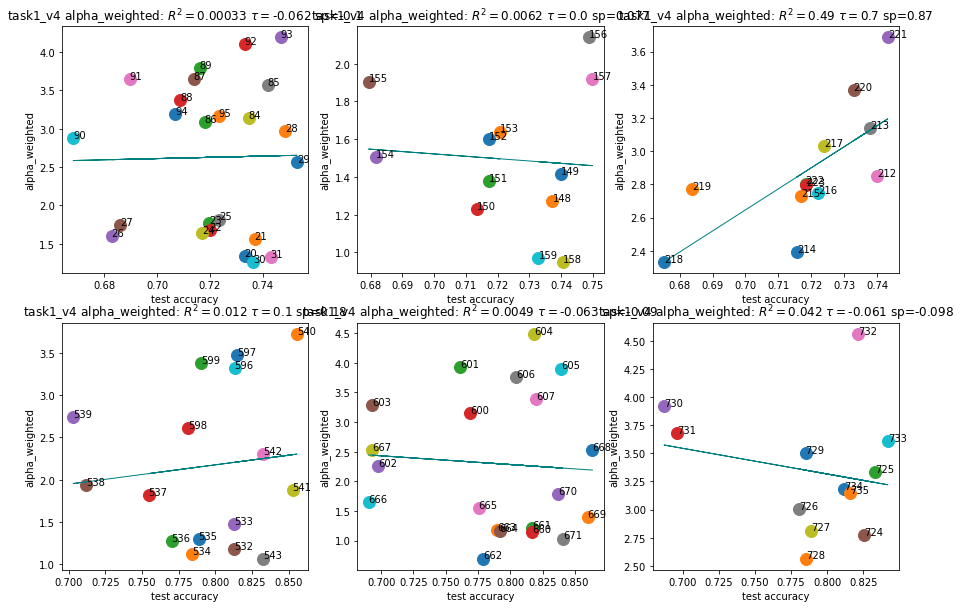

In [12]:
rcParams['figure.figsize'] = 15, 10
rcParams.update({'font.size': 10})

fig, axes = plt.subplots(2,3)
subplts = axes.flatten()[::-1].tolist()
    
for mid in [0, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]:
    these_details = {}
    for model, df in all_details.items():
        this_mid = int(model)#.replace("model_", ''))
                       
        if this_mid >= mid and this_mid < mid+100 :
            these_details[model]=df
        
    if len(these_details) > 0:
        subplt = subplts.pop()
        mgrp = U.model_group(mid)
        ahat_results[this_task][mgrp] = plot_metric('alpha_weighted', these_details, this_task, y_limit=8, subplt=subplt)

#### Task 2 Models

Repeating the analysis of weightwatcher for Task 2 is more complicated because the model groups in this set have 2 sets of very different test accuracies.  The 6xx model group has low test accuracies of $\Delta(\theta)<0.8$, whereas the other 3 model groups (2xx, 9xx, 10xx) have significantly larger test accuracies of $\Delta(\theta)>0.85$.  

It appears that $\alpha$ does correlate with test accuracy for each model group, but not for all models all depths simultaneously



In [13]:
this_task = "task2_v1"
all_details = U.read_details(this_task)

Read 54 details dataframes for task2_v1


{'RMSE': 1.9178035016638324,
 'MAE': 1.721168564394982,
 'R2': 0.021314926497385644,
 'Ktau': -0.04163265306122449,
 'spman': -0.03202881152460984}

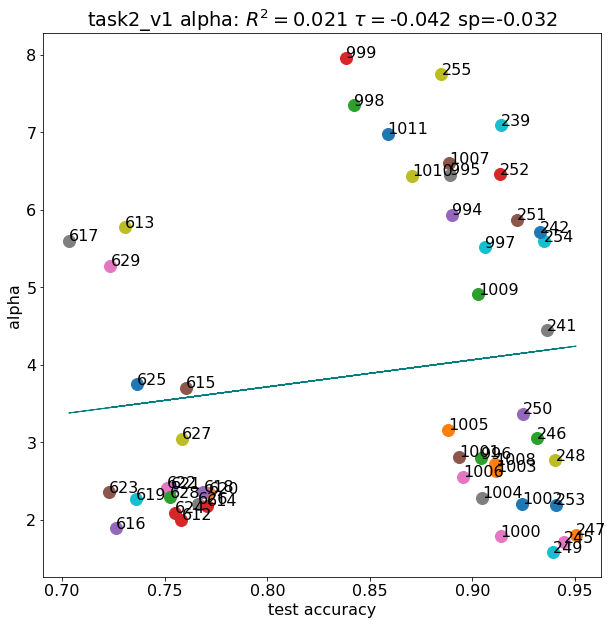

In [14]:
rcParams['figure.figsize'] = 10, 10
rcParams.update({'font.size': 16})

plot_metric('alpha', all_details, this_task, y_limit=8)

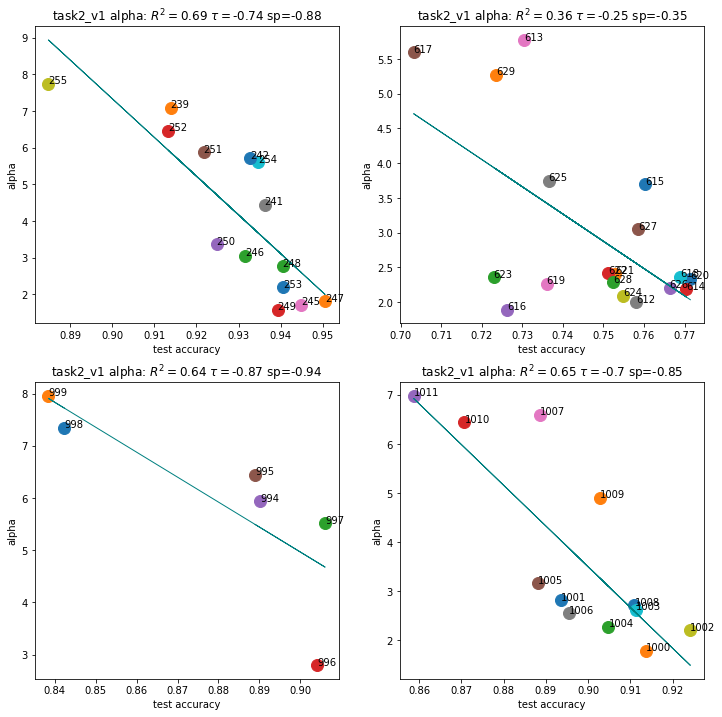

In [15]:
rcParams['figure.figsize'] = 12, 12
rcParams.update({'font.size': 10})

fig, axes = plt.subplots(2,2)
subplts = axes.flatten()[::-1].tolist()
    
for mid in [0, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]:
    these_details = {}
    for model, df in all_details.items():
        this_mid = int(model)#.replace("model_", ''))
                       
        if this_mid >= mid and this_mid < mid+100 :
            these_details[model]=df
        
    if len(these_details) > 0:
        subplt = subplts.pop()
        mgrp = U.model_group(mid)
        alpha_results[this_task][mgrp] = plot_metric('alpha', these_details, this_task, y_limit = 8, subplt=subplt)

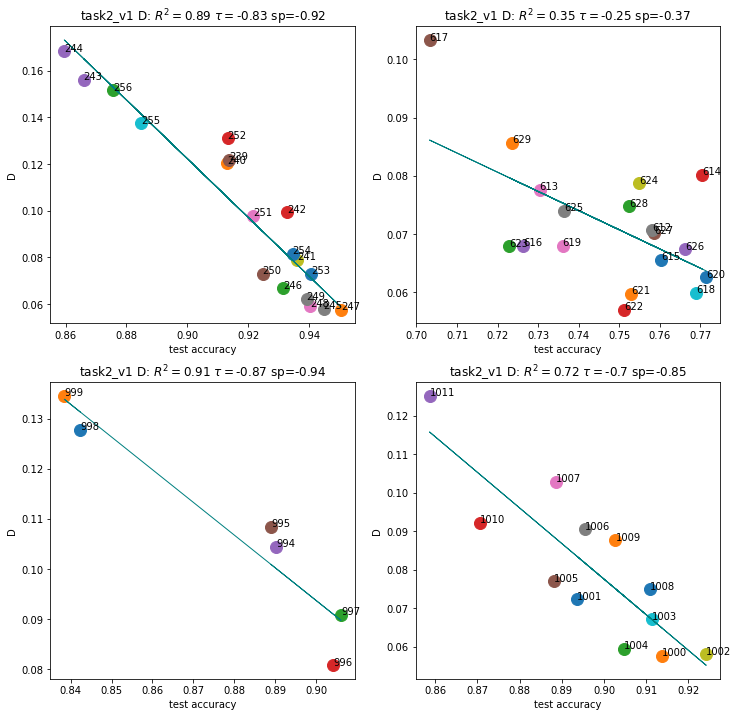

In [16]:
rcParams['figure.figsize'] = 12, 12
rcParams.update({'font.size': 10})


fig, axes = plt.subplots(2,2)
subplts = axes.flatten()[::-1].tolist()
    
for mid in [0, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]:
    these_details = {}
    for model, df in all_details.items():
        this_mid = int(model)#.replace("model_", ''))
                       
        if this_mid >= mid and this_mid < mid+100 :
            these_details[model]=df
        
    if len(these_details) > 0:
        subplt = subplts.pop()
        mgrp = U.model_group(mid)
        D_results[this_task][mgrp] = plot_metric('D', these_details, this_task, y_limit = 8, subplt=subplt)

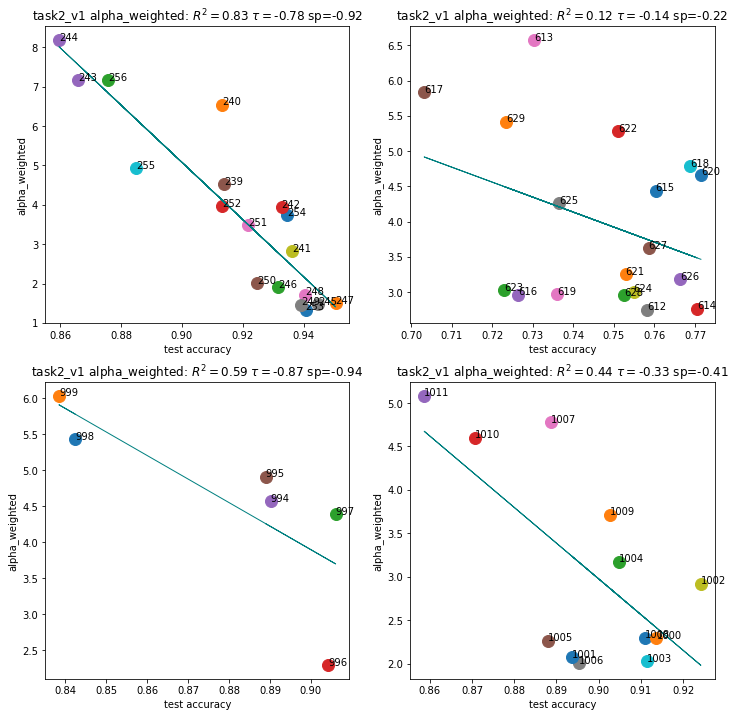

In [17]:
rcParams['figure.figsize'] = 12, 12
rcParams.update({'font.size': 10})

fig, axes = plt.subplots(2,2)
subplts = axes.flatten()[::-1].tolist()
    
for mid in [0, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]:
    these_details = {}
    for model, df in all_details.items():
        this_mid = int(model)#.replace("model_", ''))
                       
        if this_mid >= mid and this_mid < mid+100 :
            these_details[model]=df
        
    if len(these_details) > 0:
        subplt = subplts.pop()
        mgrp = U.model_group(mid)
        ahat_results[this_task][mgrp] = plot_metric('alpha_weighted', these_details, this_task, y_limit = 16, subplt=subplt)

### Extra Plots (not in paper)

Alpha vs Baseline

This is combined into Figure 8

saving ./img/baseline-vs-alpha-task1


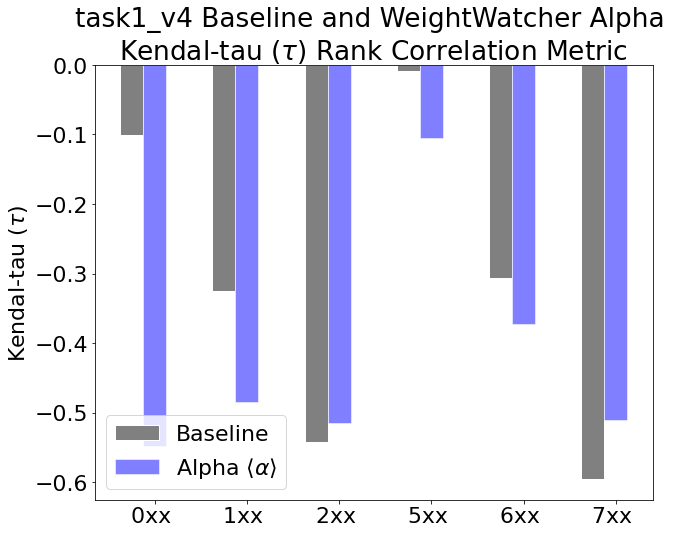

saving ./img/baseline-vs-alpha-task2


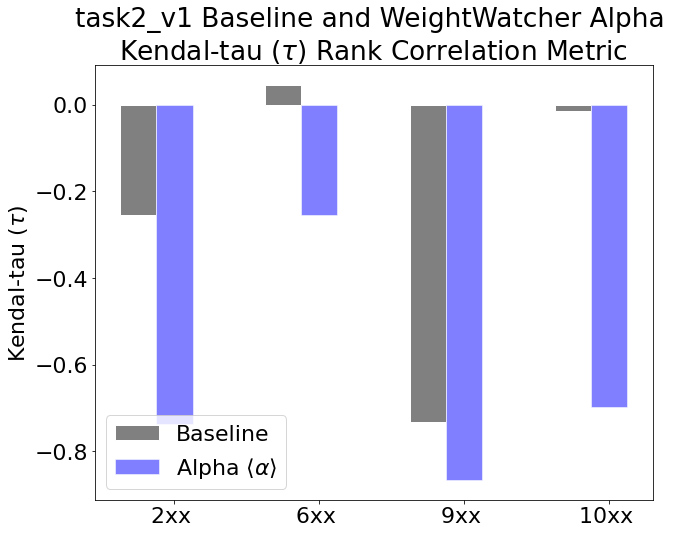

In [18]:
title = "{} Baseline and WeightWatcher Alpha \n"+ r"Kendal-tau $(\tau)$ Rank Correlation Metric"    


rcParams['figure.figsize'] = 10,8
rcParams.update({'font.size': 22})

for task in ["task1_v4", "task2_v1"]:
      
    model_grps = [k.replace(":","") for k in baseline_results[task].keys()]
    baseline_Ktau = [v['Ktau'] for v in baseline_results[task].values()]
    alpha_Ktau = [v['Ktau'] for v in alpha_results[task].values()]

    barWidth = 0.25 
    bars = model_grps
    r1 = np.arange(len(bars))
    r2 = [x + barWidth for x in r1]
    r3 = [x + barWidth for x in r2]

    plt.bar(r1, baseline_Ktau, label='Baseline', color='grey',width=barWidth, edgecolor='white')
    
    label = U.ALPHA + " " + U.AVG_ALPHA_EQN
    plt.bar(r2, alpha_Ktau, label=label, alpha=0.5, color='blue',width=barWidth, edgecolor='white')
    plt.xticks([r + barWidth for r in range(len(bars))], bars)
    
    plt.legend()
    plt.ylabel(r"Kendal-tau $(\tau)$");
    plt.title(title.format(task))
    taskname = U.taskname(task)
    filename = "{}/baseline-vs-alpha-{}".format(IMG_DIR,taskname)
    print("saving "+filename)
    plt.savefig(filename)
    plt.show()

### Table 6

Latex formating has to be changed for paper

In [65]:
df1 = pd.DataFrame(results['task1_v4'])
cols = {c:'TASKONE '+c for c in df1.columns}
df1.rename(columns=cols, inplace=True)
df1 = df1.transpose()
avg_df = df1[df1.columns].mean().to_frame()
avg_df.rename(columns={0:'TASKONE AVG'}, inplace=True)
df1=df1.append(avg_df.transpose())
display(df1)

df2 = pd.DataFrame(results['task2_v1'])
cols = {c:'TASKTWO '+c for c in df2.columns}
df2.rename(columns=cols, inplace=True)
df2 = df2.transpose()
avg_df = df2[df2.columns].mean().to_frame()
avg_df.rename(columns={0:'TASKTWO AVG'}, inplace=True)
df2=df2.append(avg_df.transpose())
display(df2)

df12 = pd.concat([df1,df2])

,R2,RMSE,Ktau
TASKONE 0xx,0.014293,0.021460,0.100974
TASKONE 1xx,0.115549,0.021158,0.325669
TASKONE 2xx,0.218041,0.017675,0.542782
TASKONE 5xx,0.006471,0.042555,0.008439
TASKONE 6xx,0.159216,0.050084,0.306883
TASKONE 7xx,0.780215,0.022391,0.595437
TASKONE AVG,0.215631,0.029220,0.313364


,R2,RMSE,Ktau
TASKTWO 2xx,0.242391,0.023734,0.254902
TASKTWO 6xx,0.023854,0.018863,-0.046054
TASKTWO 9xx,0.828812,0.011419,0.733333
TASKTWO 10xx,0.016120,0.017741,0.015268
TASKTWO AVG,0.277794,0.017939,0.239362


In [66]:
def  fix_latex_table(txt):
    """Fix a latex table for our packages"""
    txt = txt.replace("toprule",'hline')
    txt = txt.replace("midrule",'hline')
    txt = txt.replace("bottomrule",'hline')
    txt = txt.replace("TASK","\\TASK")
    return txt

In [69]:
filename = "{}/table6.tex".format(PAPER_DIR)
with open(filename, 'w') as f:
    txt = df12.to_latex( float_format="%.2f", column_format="|p{1.25in}|c|c|c|")
    table = fix_latex_table(txt)
    print(table, file=f)

In [70]:
!cat $filename

\begin{tabular}{|p{1.25in}|c|c|c|}
\hline
{} &   R2 &  RMSE &  Ktau \\
\hline
\TASKONE 0xx  & 0.01 &  0.02 &  0.10 \\
\TASKONE 1xx  & 0.12 &  0.02 &  0.33 \\
\TASKONE 2xx  & 0.22 &  0.02 &  0.54 \\
\TASKONE 5xx  & 0.01 &  0.04 &  0.01 \\
\TASKONE 6xx  & 0.16 &  0.05 &  0.31 \\
\TASKONE 7xx  & 0.78 &  0.02 &  0.60 \\
\TASKONE AVG  & 0.22 &  0.03 &  0.31 \\
\TASKTWO 2xx  & 0.24 &  0.02 &  0.25 \\
\TASKTWO 6xx  & 0.02 &  0.02 & -0.05 \\
\TASKTWO 9xx  & 0.83 &  0.01 &  0.73 \\
\TASKTWO 10xx & 0.02 &  0.02 &  0.02 \\
\TASKTWO AVG  & 0.28 &  0.02 &  0.24 \\
\hline
\end{tabular}



In [ ]:
!cp 

### Alpha-Hat Results

In [23]:
with open('baseline_results.json', 'w') as f:
    json.dump(baseline_results, f)
    
with open('alpha_results.json', 'w') as f:
    json.dump(alpha_results, f)
    
with open('ahat_results.json', 'w') as f:
    json.dump(alpha_results, f)
    
with open('D_results.json', 'w') as f:
    json.dump(D_results, f)